<a href="https://colab.research.google.com/github/mlexchange/als_ml_tutorial/blob/main/3_2_Fitting_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial we will go over how to build an object that can be used to fit data.

We will be exploring some of the functionality in pytorch aimed at providing basic insights in the underlying funcationality of the machinery that make pytorch do it's job.

The example used is a simple polynomial fitting exersize, but many of the issues we encounter directly translate to fitting neural networks.

In [14]:
#Basic numpy for arrays etc
import numpy as np
# we want to plot stuff
import matplotlib.pyplot as plt
# we will use torch
import torch
# nn contains a lot of useful things
from torch import nn
# we need optim to get optimize stuff
from torch import optim

# fix random seed
torch.manual_seed(42)


Torch libraries contain a large number of tools that overlap with numpy

In [15]:
some_values_numpy = np.linspace(0,1,3)
some_values_torch = torch.linspace(0,1,3)
print()
print("Values")
print(some_values_numpy)
print(some_values_torch)
print()
print("Sin of values")
print(np.sin(some_values_numpy))
print(torch.sin(some_values_torch))
print()
print("Types")
print(type(some_values_numpy))
print(type(some_values_torch))


Values
[0.  0.5 1. ]
tensor([0.0000, 0.5000, 1.0000])

Sin of values
[0.         0.47942554 0.84147098]
tensor([0.0000, 0.4794, 0.8415])

Types
<class 'numpy.ndarray'>
<class 'torch.Tensor'>


pytorch handles data in tensors. They feel a lot like numpy arrays.

In [16]:
sum_numpy = np.sum(some_values_numpy)
sum_torch = torch.sum(some_values_torch)

print(sum_numpy)
print(sum_torch)


1.5
tensor(1.5000)


Tensors in pytorch are different from a numpy array: they can have gradients, and they can live on different devices.

Because machine learning can be accelerated by using GPU's we need to be able to send stuff back and forth.

In [17]:
this_tensor = torch.rand(2,3, requires_grad=True, device="cpu")
print("It has gradients anfd lives on the CPU")
print(this_tensor)
print("And now we push it to the GPU")
print(this_tensor.to('cuda:0'))
print()
print(" This **grad_fn=<ToCopyBackward0>** indicates that the gradoent computation \ninvolves a copy part")
print()
print()
print("This tensor lives on the GPU")
that_tensor = torch.rand(1,2, requires_grad=True, device="cuda:0")
print(that_tensor)
print("And now we move it to the cpu")
print(that_tensor.cpu())

It has gradients anfd lives on the CPU
tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]], requires_grad=True)
And now we push it to the GPU
tensor([[0.8823, 0.9150, 0.3829],
        [0.9593, 0.3904, 0.6009]], device='cuda:0', grad_fn=<ToCopyBackward0>)

 This **grad_fn=<ToCopyBackward0>** indicates that the gradoent computation 
involves a copy part


This tensor lives on the GPU
tensor([[0.6130, 0.0101]], device='cuda:0', requires_grad=True)
And now we move it to the cpu
tensor([[0.6130, 0.0101]], grad_fn=<ToCopyBackward0>)


The biggest feature of pytorch tensors is the auto differentiation.



Lets say we have the function

$
y = x^2 + 4
$

its derivative is

$
y' = \frac{d y}{ d x} = 2 x
$

so when x is 2, y=8 and y'=4


In [18]:
# define a tensor, make sure we state that we will need to compute a derivative on it
x = torch.tensor(2.0, requires_grad=True)
# define the function
y = x*x + 4  # Define a simple mathematical operation
# compute the gradient and print it
y.backward()
print("Gradient: ", x.grad)

Gradient:  tensor(4.)


This is neat. We can get to the second derivative as well, but this requieres a bit more poking around.  Ask chatGPT how to do this.

Lets build a class that describes a function for polynomial fitting


In [19]:
class MyFunction(nn.Module): # we inherit from nn.Module
    def __init__(self, coefs): # put in initial guesses for polynomial coefficients
        super().__init__() # do the super thing
        self.coefs = nn.Parameter(coefs) #

    def forward(self, x):
        result = self.coefs[0]
        tmp = torch.ones_like(x)
        for this_coef in self.coefs[1:]:
            tmp = tmp * x # x**something
            result = result + tmp*this_coef
        return result


The **super().\__init__()** line is commonly used in the constructor method (__init__) of a subclass to call the constructor of its parent (superclass). This is important for object-oriented programming in Python, especially when you're working with inheritance. Doing so ensures that the subclass is initialized based on the behavior defined in the parent class's constructor, in addition to any new behavior you define in the subclass.


The .forward method allows you to do this:

my_output = myclass(my_data)

It is tied to the \__call__ method, which defines the behavoir of the class when called (like above)

In [20]:
funct = MyFunction(torch.rand(4))

x = torch.linspace(-1,1,100)
f = funct(x)


Let's look at this

In [8]:
plt.plot(x.numpy(),f.numpy())
plt.show()

RuntimeError: ignored

Oh! The tensor we have is still a tensor that can be used to compute a gradient on, and we can't get a numpy version of this. We can do two things:

 - get rid of the need for gradients
 - 'detach' it



In [21]:
# DETACH
f_detach = f.detach().numpy()

# no gradients computed
with torch.no_grad():
    f_no_grad = funct(x).numpy()


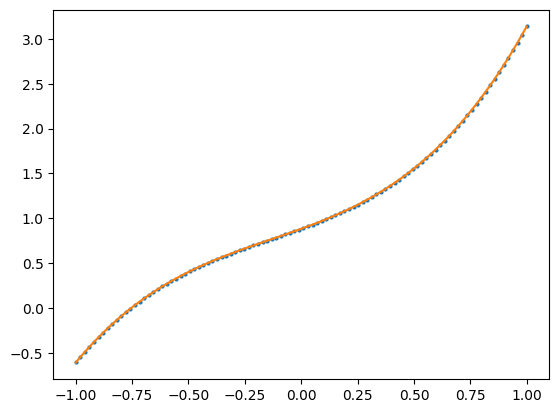

In [10]:
plt.plot(x.numpy(),f_no_grad, '.', markersize=4)
plt.plot(x.numpy(),f_detach)
plt.show()


Note this:

    self.coefs = nn.Parameter(coefs)
   
The nn.Parameter call is the notification that we want pytorch to use this tensor as parameters we want to optimize.

Lets give this a try, but on a more simple system for fitting purposes.
We first have to define a scoring function, and lets use something the torch has predefined

In [22]:
# lets use a mean squared error
loss_1 = nn.MSELoss()

Lets build a function and define some values

In [23]:
#we intialize a polynomial with 1's
funct = MyFunction(torch.Tensor([1,1]))

# the ideal polynomial has slope 2 and intercept 3
x = torch.Tensor([-1, 1])
y_obs = torch.Tensor([-2+3,2+3])

Now we use the gradient calculations via a 'backward' call

In [24]:
# gradients are accumulated, so make sure that we have a zero-array when we start
if funct.coefs.grad is not None:
    funct.coefs.grad.zero_()

y_pred = funct(x) # compute the function
loss_actual = loss_1(y_pred, y_obs)
loss_actual.backward()

print(funct.coefs.grad)

tensor([-4., -2.])


Lets minimize the function.

We will use first derivatives only, so we will need to guess a step size. Here we will simply multiple the gradient by a small number and use that as a step size.

Here is what we will do in a loop

- Get the loss function
- compute the gradient
- scale them by a factor
- get the new coefficients
- make new coefficients
- make a new object




In [25]:
funct = MyFunction(torch.Tensor([0,0]))
step_size = 0.1

for ii in range(50):
    y_pred = funct(x) # coimpute function
    loss_actual = loss_1(y_pred, y_obs) # get the loss
    loss_actual.backward() # compute gradients
    step = funct.coefs.grad*step_size # scale the gradients
    funct = MyFunction(funct.coefs - step) # make a new function
    #-------------- Printing stuff --------------
    tmp = funct.coefs.detach().numpy() - step.numpy() #for printing
    new_a = funct.coefs.detach()[0].item() - step[0].item()
    new_b = funct.coefs.detach()[1].item() - step[1].item()
    if ii%2==0:
        print( f"iteration {ii:04} coef-a: {new_a:3.2f} coef-b: {new_b:3.2f} loss function {loss_actual.item():4.3f}")



iteration 0000 coef-a: 1.20 coef-b: 0.80 loss function 13.000
iteration 0002 coef-a: 1.85 coef-b: 1.23 loss function 5.325
iteration 0004 coef-a: 2.26 coef-b: 1.51 loss function 2.181
iteration 0006 coef-a: 2.53 coef-b: 1.69 loss function 0.893
iteration 0008 coef-a: 2.70 coef-b: 1.80 loss function 0.366
iteration 0010 coef-a: 2.81 coef-b: 1.87 loss function 0.150
iteration 0012 coef-a: 2.88 coef-b: 1.92 loss function 0.061
iteration 0014 coef-a: 2.92 coef-b: 1.95 loss function 0.025
iteration 0016 coef-a: 2.95 coef-b: 1.97 loss function 0.010
iteration 0018 coef-a: 2.97 coef-b: 1.98 loss function 0.004
iteration 0020 coef-a: 2.98 coef-b: 1.99 loss function 0.002
iteration 0022 coef-a: 2.99 coef-b: 1.99 loss function 0.001
iteration 0024 coef-a: 2.99 coef-b: 1.99 loss function 0.000
iteration 0026 coef-a: 2.99 coef-b: 2.00 loss function 0.000
iteration 0028 coef-a: 3.00 coef-b: 2.00 loss function 0.000
iteration 0030 coef-a: 3.00 coef-b: 2.00 loss function 0.000
iteration 0032 coef-a: 

While this works, this is far from optimal.
Here are some issues with how we do things

- *What is a good step size?*

When we have a very large model, computing second derivatives isn't really an option. Also, Machine Learning is not optimizing a function per se, it's finding some function that has properties you desire, such as being able to predict values.

Instead of using our silly gradients $\times$ step, we can use an optimizer that takes care of some details
(we still need to define a learning rate though)

- *Why do we need to make a new model?*

We don't, but we can't just change the self.coefs values either, because they are nn.Parameter objects and other steops are involved. blabla gradients blabla computational graph most likely. This is actually taken care of by the optimizer as shown in a bit.


- *Why is the multiplier fixed? Shouldn't it vary like when we have newtons method?*

Yes it should. We actually can have it slowly / rapidly change over the course of our optimization. This is called a scheduler. There are many of those available. Some dynamic behavoir is availavble within various optimizers, like SGD or Adam and its cousins.

- *Even when we scale things down, my functions can have a so-called exploding gradient, i.e. things can go get very large and go to infinity, and I will get NaNs.*

That is indeed a problem. To combat this, we can use gradient clipping, i.e. do not allow any element with the gradient to be above a certain value in the absolute sense.


Let incorporate this and make our data a little more complicated

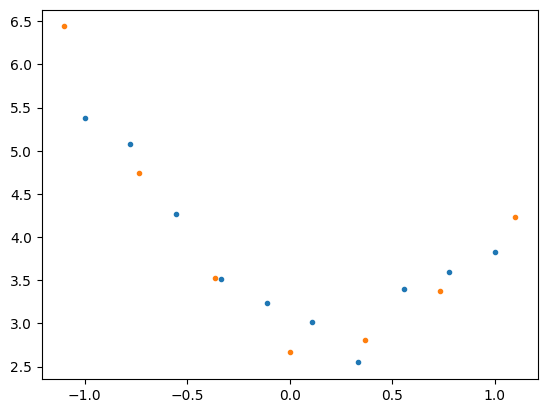

In [26]:
SIGMA=.25 # noise levels
N_obs = 10 # number of observations

# train data
x = torch.linspace(-1,1,N_obs)
y_obs = 2*x*x - x + 3 + torch.normal(0, SIGMA, x.shape)

# test data
x_test = torch.linspace(-1.1,1.1,N_obs-3)
y_test = 2*x_test*x_test - x_test + 3 + torch.normal(0, SIGMA, x_test.shape)

plt.plot(x.numpy(), y_obs.numpy(), '.')
plt.plot(x_test.numpy(), y_test.numpy(), '.')
plt.show()



In [27]:
# lets make a random polynomial with 3 terms
funct = MyFunction(torch.rand(3))


n_epochs = 250 # we train 250 epochs
learning_rate=.1 # learning rate is 0.1
max_norm = 100 # gradient clipping!

# choose your minimizer
optimizer = optim.Adam(funct.parameters(), lr=learning_rate)
#optimizer = optim.AdamW(funct.parameters(), lr=learning_rate)
#optimizer = optim.SGD(funct.parameters(), lr=learning_rate)

# our scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9995)  # Reduce LR every 10 steps

# our loss function
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

# Training loop
for ii in range(n_epochs):
    optimizer.zero_grad()  # Zero out gradients

    y_pred = funct(x)  # Compute function
    loss_actual = criterion(y_pred, y_obs)  # Get the loss

    loss_actual.backward()  # Compute gradients

    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(funct.parameters(), max_norm=max_norm)

    optimizer.step()  # Update parameters

    # Learning rate scheduling
    scheduler.step()

    new_a = funct.coefs.detach()[0].item()
    new_b = funct.coefs.detach()[1].item()
    new_c = funct.coefs.detach()[2].item()
    if not ii%10 :
        print(f"iteration {ii:04} coef-a: {new_a:3.2f} coef-b: {new_b:3.2f} coef-c: {new_c:3.2f}  loss function {loss_actual.item():4.3f}")


iteration 0000 coef-a: 0.89 coef-b: 0.49 coef-c: 0.85  loss function 8.262
iteration 0010 coef-a: 1.85 coef-b: -0.46 coef-c: 1.81  loss function 1.898
iteration 0020 coef-a: 2.61 coef-b: -1.06 coef-c: 2.52  loss function 0.195
iteration 0030 coef-a: 2.96 coef-b: -1.11 coef-c: 2.72  loss function 0.294
iteration 0040 coef-a: 2.96 coef-b: -0.89 coef-c: 2.50  loss function 0.194
iteration 0050 coef-a: 2.86 coef-b: -0.78 coef-c: 2.19  loss function 0.090
iteration 0060 coef-a: 2.85 coef-b: -0.84 coef-c: 1.99  loss function 0.080
iteration 0070 coef-a: 2.93 coef-b: -0.89 coef-c: 1.93  loss function 0.065
iteration 0080 coef-a: 3.01 coef-b: -0.88 coef-c: 1.89  loss function 0.056
iteration 0090 coef-a: 3.05 coef-b: -0.86 coef-c: 1.83  loss function 0.053
iteration 0100 coef-a: 3.06 coef-b: -0.86 coef-c: 1.76  loss function 0.050
iteration 0110 coef-a: 3.07 coef-b: -0.87 coef-c: 1.72  loss function 0.050
iteration 0120 coef-a: 3.09 coef-b: -0.87 coef-c: 1.70  loss function 0.049
iteration 013

We can use other optimizers, like l-BFGS, that provide approximate second order accelration. The training loop needs to be modified slightly though.

In [28]:
funct = MyFunction(torch.rand(3))
optimizer = optim.LBFGS(funct.parameters(), lr=0.1, max_iter=200, history_size=100)  # Using L-BFGS optimizer
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

# Function for closure, required for LBFGS
def closure():
    optimizer.zero_grad()  # Zero out gradients
    y_pred = funct(x)  # Compute function
    loss_actual = criterion(y_pred, y_obs)  # Get the loss
    loss_actual.backward()  # Compute gradients
    #print("in closure")
    return loss_actual

# Training loop
for ii in range(5):
    optimizer.step(closure)  # Optimizer step
    loss_actual = closure()

    new_a = funct.coefs.detach()[0].item()
    new_b = funct.coefs.detach()[1].item()
    new_c = funct.coefs.detach()[2].item()

    print(f"iteration {ii:04} coef-a: {new_a:3.2f} coef-b: {new_b:3.2f} coef-c: {new_c:3.2f}  loss function {loss_actual.item():4.3f}")


iteration 0000 coef-a: 3.11 coef-b: -0.87 coef-c: 1.67  loss function 0.049
iteration 0001 coef-a: 3.11 coef-b: -0.87 coef-c: 1.67  loss function 0.049
iteration 0002 coef-a: 3.11 coef-b: -0.87 coef-c: 1.67  loss function 0.049
iteration 0003 coef-a: 3.11 coef-b: -0.87 coef-c: 1.67  loss function 0.049
iteration 0004 coef-a: 3.11 coef-b: -0.87 coef-c: 1.67  loss function 0.049


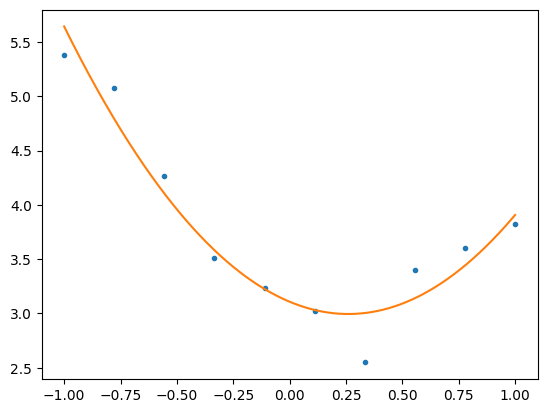

In [29]:
x_for_plotting = torch.linspace(-1,1,1000)
with torch.no_grad():
    y_pred = funct(x_for_plotting)
plt.plot(x.numpy(), y_obs.numpy(), '.')
plt.plot(x_for_plotting.numpy(), y_pred.numpy())
plt.show()

This is the end of this tutorial, at least, the basic part. Below, we will do some more advanced things, like regularizing our model to make sure we don't overfit. These issues will pop up in general machine learning tasks, and are explored in a more simplified environment here.



-------------------------------------------------------------------------

**Are you sure you want to continue? Be warned, I might have overdone things a bit.....**

In [30]:
# we need two extra imports
!pip install einops
import einops
import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.1 MB/s eta 0:00:00


Lets do some overfitting! We only have 10 data points, but lets fit a 15 parameter polynomial.

In [31]:
K=15
funct = MyFunction(torch.ones(K))

n_epochs = 500
learning_rate=0.1
max_norm = 100

optimizer = optim.Adam(funct.parameters(), lr=learning_rate)
#optimizer = optim.SGD(funct.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.995)  # Reduce LR every 10 steps
criterion = nn.MSELoss()


# Training loop
for ii in range(n_epochs):
    optimizer.zero_grad()  # Zero out gradients

    y_pred = funct(x)  # Compute function
    loss_actual = criterion(y_pred, y_obs)  # Get the loss

    loss_actual.backward()  # Compute gradients

    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(funct.parameters(), max_norm=max_norm)

    optimizer.step()  # Update parameters

    # Learning rate scheduling
    scheduler.step()

    if not ii%100 :
        print(f"iteration {ii:04}  loss function {loss_actual.item():4.3f}")

iteration 0000  loss function 19.727
iteration 0100  loss function 0.026
iteration 0200  loss function 0.024
iteration 0300  loss function 0.023
iteration 0400  loss function 0.023


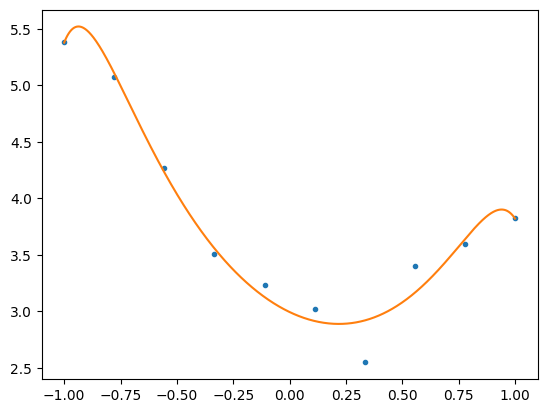

Parameter containing:
tensor([ 2.9946, -0.9536,  2.1419, -0.0266,  0.5412,  0.0196, -0.1843,  0.0240,
        -0.2902,  0.0387, -0.2504,  0.0538, -0.1966,  0.0653, -0.1556],
       requires_grad=True)


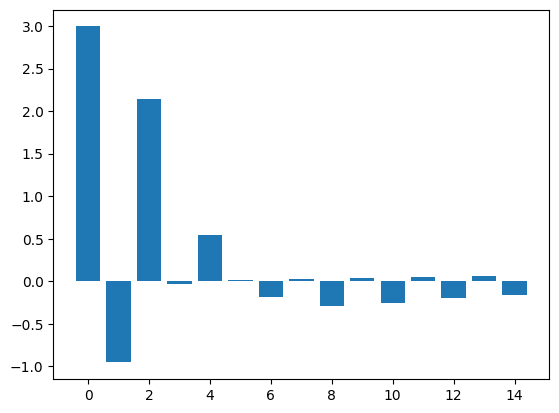

In [32]:
with torch.no_grad():
    y_pred = funct(x_for_plotting)
plt.plot(x.numpy(), y_obs.numpy(), '.')
plt.plot(x_for_plotting.numpy(), y_pred.numpy())
plt.show()
print(funct.coefs)
plt.bar(np.arange(len(funct.coefs)), funct.coefs.detach().numpy())
plt.show()

As you can see, the results are all over the place and the polynomial we have fits really nicely, but is obviously overfitting the data.

Lets define some way to constrain out polynomial coefficients. We build a function that close to 0 when inpout if close to zero, rises rapidly to 1 when not.

We can then use this as an added term during minimization on top of the MSE or L1 loss.


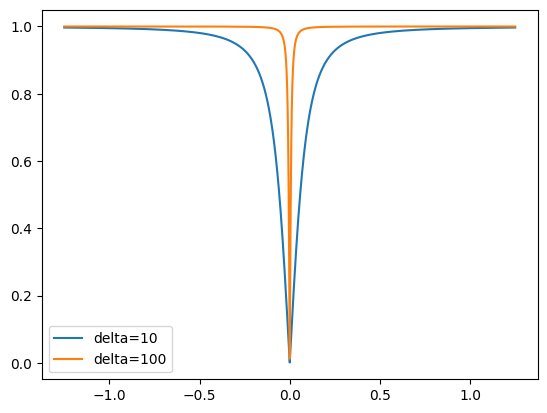

In [33]:
t = torch.linspace(-1.25, 1.25, 10000)
ft = t*10
ft = (ft**2/(1+ft**2))**.5
plt.plot(t,ft)
ft = t*100
ft = (ft**2/(1+ft**2))**.5
plt.plot(t,ft)
plt.legend(['delta=10','delta=100'])
plt.show()

In [34]:
# our well function that encourages stuff to be zero / small
def well_function(coefs, delta, power=.5):
    tmp = coefs*delta
    tmp = (tmp**2/(1+tmp**2))**power
    return torch.sum(tmp)/len(coefs)

# here we combine our custom well function with a standard loss
class CustomLoss(nn.Module): # we inherit from nn.Module
    def __init__(self, base_loss, weight, delta):
        super().__init__()
        self.base_loss = base_loss
        self.weight = weight
        self.delta = delta

    def forward(self, y_pred, y_obs, params):
        part1 = self.base_loss(y_pred, y_obs)
        part2 = well_function(params, self.delta)
        return part1 + self.weight*part2


Lets give this a try. for now, we set the weight of the added term to 1 and the delta (determining the width) to 10.

In [35]:
K = 15
funct = MyFunction(torch.ones(K))

n_epochs = 500
learning_rate=.1
max_norm = 100

optimizer = optim.Adam(funct.parameters(), lr=learning_rate)
#optimizer = optim.SGD(funct.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)  # Reduce LR every 10 steps

criterion = CustomLoss(nn.MSELoss(),
                       weight = 1,
                       delta = 10.0)


# Training loop
for ii in range(n_epochs):
    optimizer.zero_grad()  # Zero out gradients
    y_pred = funct(x)  # Compute function
    loss_actual = criterion(y_pred, y_obs, funct.coefs)  # Get the loss
    loss_actual.backward()  # Compute gradients
    torch.nn.utils.clip_grad_norm_(funct.parameters(), max_norm=max_norm)
    optimizer.step()  # Update parameters
    scheduler.step()

    if not ii%100:
        print(f"iteration {ii:04} loss function {loss_actual.item():4.3f}")


iteration 0000 loss function 20.722
iteration 0100 loss function 0.435
iteration 0200 loss function 0.372
iteration 0300 loss function 0.369
iteration 0400 loss function 0.366


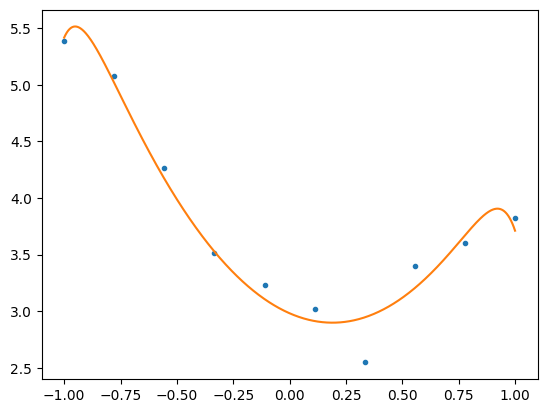

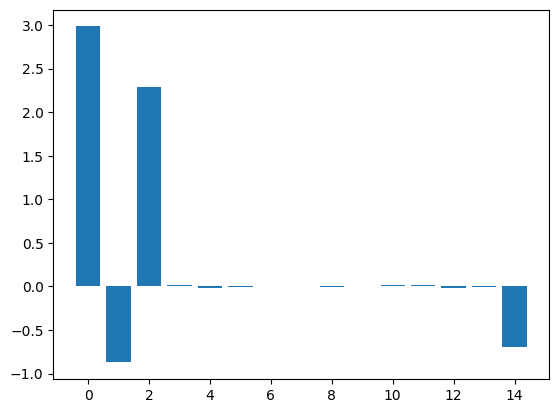

Parameter containing:
tensor([ 2.9825e+00, -8.7202e-01,  2.2899e+00,  1.3666e-02, -1.3804e-02,
        -1.0997e-02,  6.1613e-03,  2.7837e-03, -3.0754e-03,  9.4529e-03,
         1.2995e-02,  1.4468e-02, -1.7551e-02, -9.5420e-03, -6.9327e-01],
       requires_grad=True)


In [36]:
xx = torch.linspace(-1,1,1000)
with torch.no_grad():
    y_pred = funct(xx)
plt.plot(x.numpy(), y_obs.numpy(), '.')
plt.plot(xx.numpy(), y_pred.numpy())
plt.show()

plt.bar(np.arange(len(funct.coefs)), funct.coefs.detach().numpy())
plt.show()
print(funct.coefs)

This is less wild! We however need to make a decision on the hyper parameters of the constraint function. Lets check this out with a cross validation approach.

We optimize on the train data, using our custom loss function, and we do validation on our base loss / MSE value. Our modified loss function tightens the space of our model, similar to choosing the number of polynomials. We are principally interested in how well we can predict observations in an MSE / L1 norm, so that is what we judge our model choice by.  

In [37]:
def optimize_me(x,y,x_test,y_test, weight, delta):

    funct = MyFunction(torch.rand(K)*2-1)
    n_epochs = 500
    learning_rate=1e-1
    max_norm = 100
    optimizer = optim.Adam(funct.parameters(), lr=learning_rate)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)  # Reduce LR every 10 steps
    base_loss = nn.MSELoss()
    criterion = CustomLoss(base_loss, weight, delta)


    # Training loop
    for ii in range(n_epochs):
        optimizer.zero_grad()  # Zero out gradients
        y_pred = funct(x)  # Compute function
        loss_actual = criterion(y_pred, y_obs, funct.coefs)  # Get the loss
        loss_actual.backward()  # Compute gradients
        torch.nn.utils.clip_grad_norm_(funct.parameters(), max_norm=max_norm)
        optimizer.step()  # Update parameters
        scheduler.step()

    with torch.no_grad():
        tmp = funct(x_test)
        test_loss = base_loss(tmp,y_test)
    return test_loss.item(), funct.coefs


In [38]:
# just try a couple of combinations
weights = [1,2,3,4]
deltas = [0.01, 0.1, 1]
params = []
means = []
stds = []
coefs = []
this_one = 0
this_score = 1e90
count = 0
for w in tqdm.tqdm(weights):
    for d in deltas:
        vals = []
        coefs_ens = []
        params.append((w,d))
        for ii in range(3): # because there is randomization going on, we can't really rely on a single trial
            tmp,tmp_coefs = optimize_me(x,y_obs, x_test, y_test, w, d)
            vals.append(tmp)
            coefs_ens.append(tmp_coefs.detach().clone())
        means.append(np.mean(np.array(vals)))
        stds.append(np.std(np.array(vals)))
        coefs.append(coefs_ens)
        if means[-1] < this_score:
            this_score = means[-1]
            this_one = count
        count += 1

100%|██████████| 4/4 [00:21<00:00,  5.44s/it]


Now that we have explored a number of optiosn, lets plots them. We need to take the loss values and reshape the array. the einops library is really usefull. It retains gradients and you can use this as part of your networks if desired.

In [39]:
means_s = einops.rearrange(np.array(means), "(Y X) -> Y X", Y=4, X=3)
print(np.array(means).shape, means_s.shape)

(12,) (4, 3)


Plot this thing

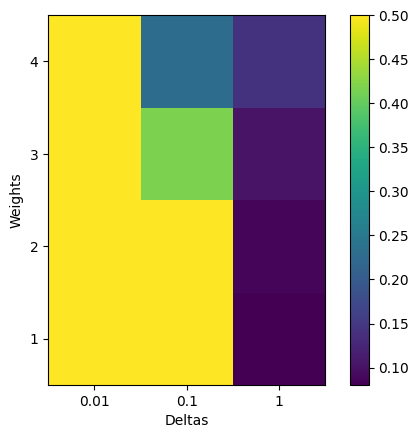

In [40]:

# Create the plot
fig, ax = plt.subplots()
cax = ax.imshow((means_s), cmap='viridis', interpolation='None', origin='lower', vmax=0.5)

# Add color bar
cbar = fig.colorbar(cax, orientation='vertical')

# Set axis labels
ax.set_xticks(np.arange(len(deltas)))
ax.set_yticks(np.arange(len(weights)))
ax.set_xticklabels(deltas)
ax.set_yticklabels(weights)

# Label the axes
ax.set_xlabel('Deltas')
ax.set_ylabel('Weights')

# Show the plot
plt.show()


Find the best one

In [41]:
selected_coefs = einops.rearrange( coefs[this_one], "N C -> N C")

Because we have 5 of them, we can get some population statistics.

Do not over interpret this! If the minimizer is ideal / if you are lucky, you will always converge to the lowest point and all your coefficients are the same....

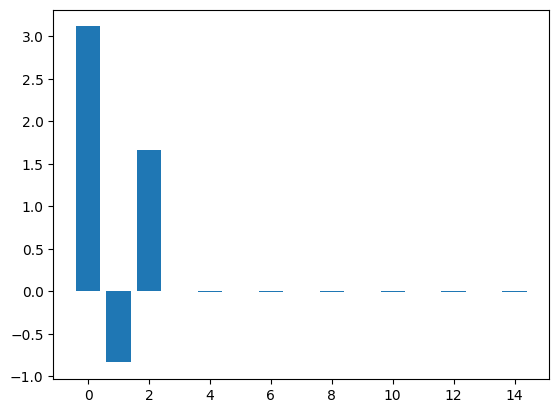

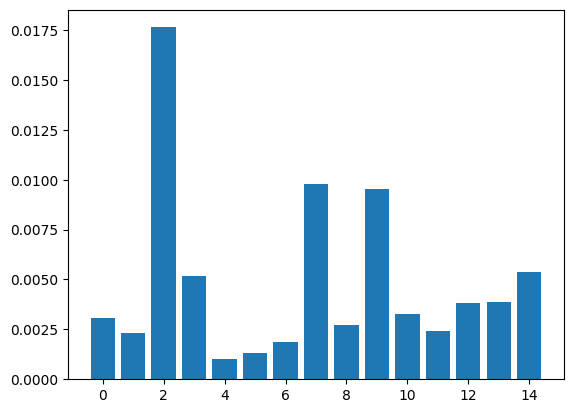

In [42]:
plt.bar( np.arange(K), torch.mean(selected_coefs, dim=0))
plt.show()
plt.bar( np.arange(K), torch.std(selected_coefs, dim=0))
plt.show()


Lets plot every model

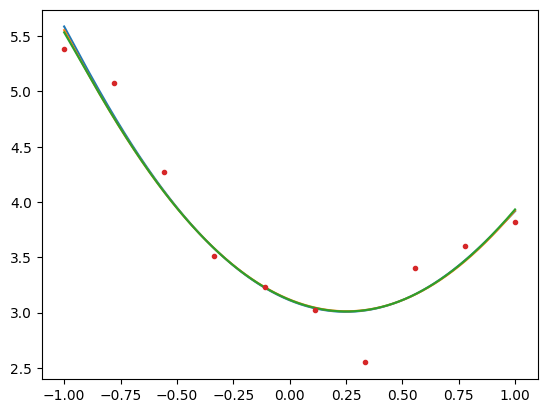

In [43]:
x_for_plotting = torch.linspace(-1,1,1000)
for cc in selected_coefs:
    ff = MyFunction(cc)
    with torch.no_grad():
        yy = ff(x_for_plotting)
    plt.plot(x_for_plotting, yy)
plt.plot(x, y_obs, '.')
plt.show()




Lets take all our data and put it together now that we have decided on what model to fit

In [44]:
x_all = torch.concatenate([x, x_test])
y_all = torch.concatenate([y_obs, y_test])
print(x_all.shape, y_all.shape)

torch.Size([17]) torch.Size([17])


Pick the best weight and delta

In [45]:
this_w, this_d = params[this_one]
print(f'Weight {this_w:3.2e} Delta {this_d:3.2e}')

funct = MyFunction(torch.ones(K))
n_epochs = 150
learning_rate=.1
max_norm = 1

optimizer = optim.Adam(funct.parameters(), lr=learning_rate)
#optimizer = optim.SGD(funct.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.999)  # Reduce LR every 10 steps
criterion = CustomLoss(nn.MSELoss(),this_w, this_d)


# Training loop
for ii in range(n_epochs):
    optimizer.zero_grad()  # Zero out gradients
    y_pred = funct(x)  # Compute function
    loss_actual = criterion(y_pred, y_obs, funct.coefs)  # Get the loss
    loss_actual.backward()  # Compute gradients
    torch.nn.utils.clip_grad_norm_(funct.parameters(), max_norm=max_norm)
    optimizer.step()  # Update parameters
    scheduler.step()

    if not ii%10:
        print(f"iteration {ii:04} loss function {loss_actual.item():4.3f}")


Weight 1.00e+00 Delta 1.00e+00
iteration 0000 loss function 20.434
iteration 0010 loss function 1.796
iteration 0020 loss function 0.610
iteration 0030 loss function 0.414
iteration 0040 loss function 0.270
iteration 0050 loss function 0.240
iteration 0060 loss function 0.233
iteration 0070 loss function 0.226
iteration 0080 loss function 0.221
iteration 0090 loss function 0.220
iteration 0100 loss function 0.219
iteration 0110 loss function 0.217
iteration 0120 loss function 0.217
iteration 0130 loss function 0.216
iteration 0140 loss function 0.217


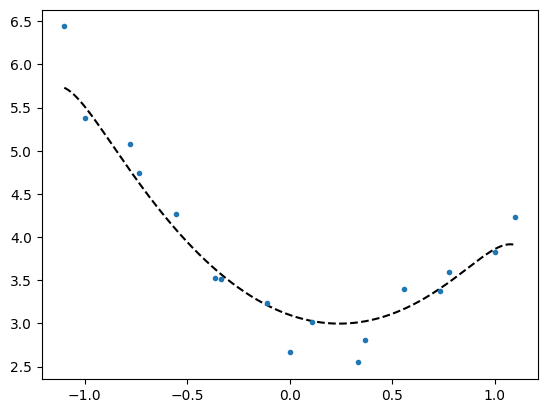

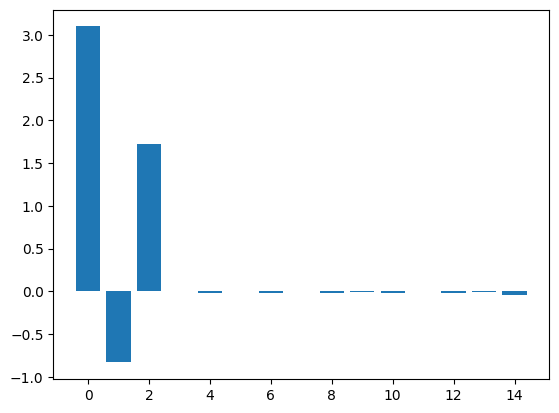

In [46]:
x_for_plotting = torch.linspace(-1.1,1.1,1000)
with torch.no_grad():
    y_for_plotting = funct(x_for_plotting)

plt.plot(x_for_plotting.numpy(), y_for_plotting.numpy(), '--', c='black')
plt.plot(x_all, y_all, '.')
plt.show()
plt.bar( np.arange(K), funct.coefs.detach())
plt.show()

Instead of using a custom loss function, we can instead try and use other tools. L1 minimization is know to induce sparsity.

iteration 0000 loss function 3.367
iteration 0010 loss function 1.482
iteration 0020 loss function 0.494
iteration 0030 loss function 0.349
iteration 0040 loss function 0.216
iteration 0050 loss function 0.128
iteration 0060 loss function 0.142
iteration 0070 loss function 0.104
iteration 0080 loss function 0.098
iteration 0090 loss function 0.110
iteration 0100 loss function 0.106
iteration 0110 loss function 0.102
iteration 0120 loss function 0.110
iteration 0130 loss function 0.115
iteration 0140 loss function 0.101
iteration 0150 loss function 0.140
iteration 0160 loss function 0.140
iteration 0170 loss function 0.109
iteration 0180 loss function 0.089
iteration 0190 loss function 0.126
iteration 0200 loss function 0.105
iteration 0210 loss function 0.094
iteration 0220 loss function 0.096
iteration 0230 loss function 0.101
iteration 0240 loss function 0.094


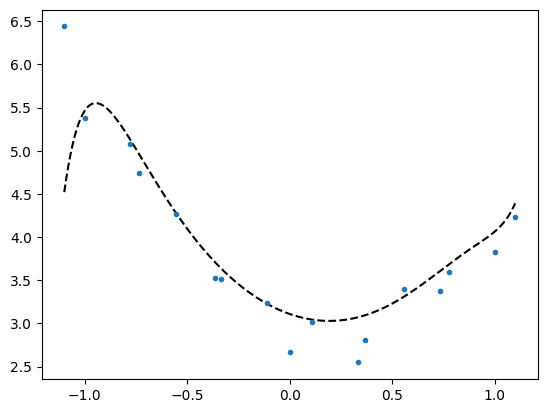

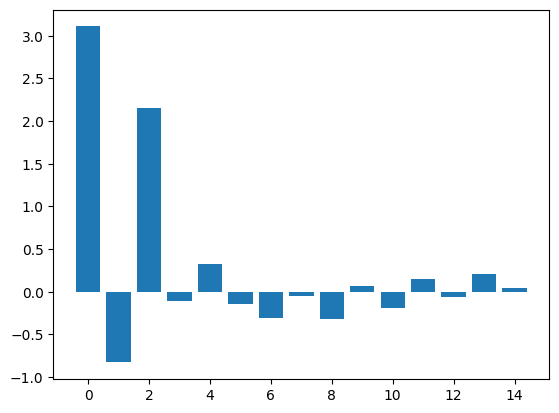

In [47]:
funct = MyFunction(torch.ones(K))
n_epochs = 250
learning_rate=.1
max_norm = 10

optimizer = optim.Adam(funct.parameters(), lr=learning_rate)
#optimizer = optim.SGD(funct.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.999)  # Reduce LR every 10 steps
criterion = nn.L1Loss()


# Training loop
for ii in range(n_epochs):
    optimizer.zero_grad()  # Zero out gradients
    y_pred = funct(x)  # Compute function
    loss_actual = criterion(y_pred, y_obs)  # Get the loss
    loss_actual.backward()  # Compute gradients
    torch.nn.utils.clip_grad_norm_(funct.parameters(), max_norm=max_norm)
    optimizer.step()  # Update parameters
    scheduler.step()

    if not ii%10:
        print(f"iteration {ii:04} loss function {loss_actual.item():4.3f}")
x_for_plotting = torch.linspace(-1.1,1.1,1000)
with torch.no_grad():
    y_for_plotting = funct(x_for_plotting)

plt.plot(x_for_plotting.numpy(), y_for_plotting.numpy(), '--', c='black')
plt.plot(x_all, y_all, '.')
plt.show()
plt.bar( np.arange(K), funct.coefs.detach())
plt.show()

Nope.

We can use __weight decay__. This adds in an L2 penalty on coefficients we refine, i.e.

the loss term + sum(coefs**2)

iteration 0000 loss function 3.787
iteration 0010 loss function 3.505
iteration 0020 loss function 3.227
iteration 0030 loss function 2.952
iteration 0040 loss function 2.680
iteration 0050 loss function 2.419
iteration 0060 loss function 2.185
iteration 0070 loss function 2.130
iteration 0080 loss function 2.053
iteration 0090 loss function 1.978
iteration 0100 loss function 1.906
iteration 0110 loss function 1.834
iteration 0120 loss function 1.768
iteration 0130 loss function 1.701
iteration 0140 loss function 1.635
iteration 0150 loss function 1.566
iteration 0160 loss function 1.499
iteration 0170 loss function 1.434
iteration 0180 loss function 1.367
iteration 0190 loss function 1.301
iteration 0200 loss function 1.236
iteration 0210 loss function 1.170
iteration 0220 loss function 1.109
iteration 0230 loss function 1.043
iteration 0240 loss function 0.979
iteration 0250 loss function 0.918
iteration 0260 loss function 0.855
iteration 0270 loss function 0.794
iteration 0280 loss 

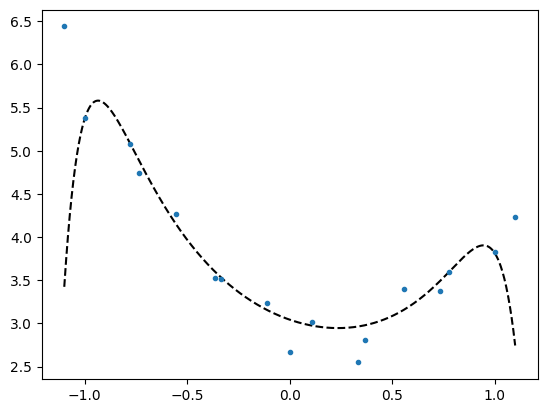

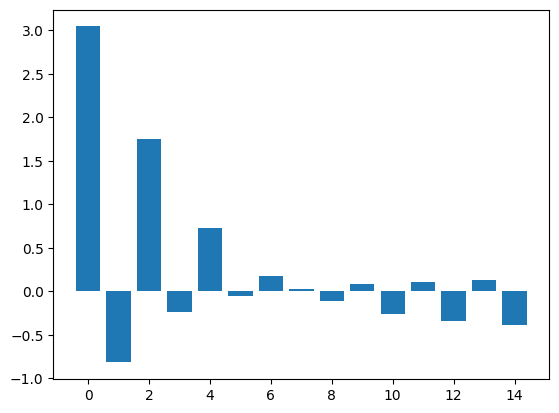

In [48]:
funct = MyFunction(torch.zeros(K))
n_epochs = 500
learning_rate=.01
max_norm = 100
weight_decay_parameter=2e-2
optimizer = optim.Adam(funct.parameters(), lr=learning_rate, weight_decay=weight_decay_parameter)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)  # Reduce LR every 10 steps
criterion = nn.L1Loss()


# Training loop
for ii in range(n_epochs):
    optimizer.zero_grad()  # Zero out gradients
    y_pred = funct(x)  # Compute function
    loss_actual = criterion(y_pred, y_obs)  # Get the loss
    loss_actual.backward()  # Compute gradients
    torch.nn.utils.clip_grad_norm_(funct.parameters(), max_norm=max_norm)
    optimizer.step()  # Update parameters
    scheduler.step()

    if not ii%10:
        print(f"iteration {ii:04} loss function {loss_actual.item():4.3f}")


x_for_plotting = torch.linspace(-1.1,1.1,1000)
with torch.no_grad():
    y_for_plotting = funct(x_for_plotting)

plt.plot(x_for_plotting.numpy(), y_for_plotting.numpy(), '--', c='black')
plt.plot(x_all, y_all, '.')
plt.show()
plt.bar( np.arange(K), funct.coefs.detach())
plt.show()

Note that it is very easy to get creative and perhap overboard.
 Because we don't need to derive derivatives ourselves, we can try weird stuff very easely



In [49]:
# our well function that encourages stuff to be zero / small
def targeted_well_function(coefs, delta, power=.5, target = 3):
    tmp = coefs*delta
    tmp = (tmp**2/(1+tmp**2))**power
    tmp = (torch.sum(tmp) - target)**2
    return tmp

# here we combine our custom well function with a standard loss
class OverboardLoss(nn.Module): # we inherit from nn.Module
    def __init__(self, base_loss, weight, delta, target):
        super().__init__()
        self.base_loss = base_loss
        self.weight = weight
        self.delta = delta
        self.target = target

    def forward(self, y_pred, y_obs, params):
        part1 = self.base_loss(y_pred, y_obs)
        part2 = targeted_well_function(params, self.delta, 0.5, self.target)
        return part1 + self.weight*part2


In the above loss function we drive the polynomial to have __target__ non-zero terms. The more complicated your loss function , harder it often is to minimize it.

iteration 0000 loss function 91.503
iteration 0100 loss function 12.815
iteration 0200 loss function 1.040
iteration 0300 loss function 0.749
iteration 0400 loss function 0.533
iteration 0500 loss function 0.433
iteration 0600 loss function 0.340
iteration 0700 loss function 0.293
iteration 0800 loss function 0.237
iteration 0900 loss function 0.232
iteration 1000 loss function 0.212
iteration 1100 loss function 0.144
iteration 1200 loss function 0.134
iteration 1300 loss function 0.111
iteration 1400 loss function 0.089


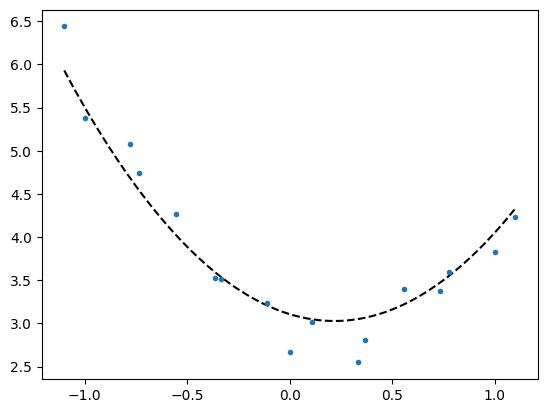

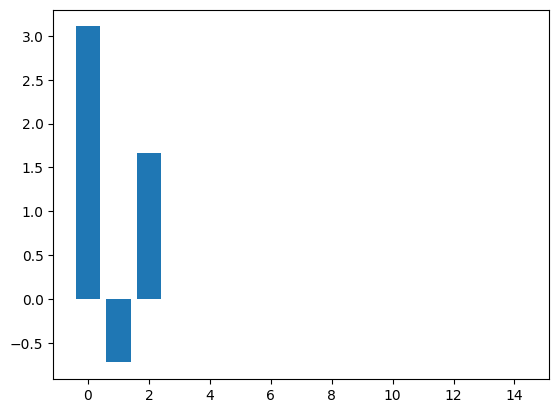

In [50]:

funct = MyFunction(torch.ones(K))
n_epochs = 1500
learning_rate=.01
max_norm = 1

optimizer = optim.Adam(funct.parameters(), lr=learning_rate)
#optimizer = optim.SGD(funct.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.999)  # Reduce LR every 10 steps
criterion = OverboardLoss(nn.MSELoss(),.5, 20, 3)


# Training loop
for ii in range(n_epochs):
    optimizer.zero_grad()  # Zero out gradients
    y_pred = funct(x)  # Compute function
    loss_actual = criterion(y_pred, y_obs, funct.coefs)  # Get the loss
    loss_actual.backward()  # Compute gradients
    torch.nn.utils.clip_grad_norm_(funct.parameters(), max_norm=max_norm)
    optimizer.step()  # Update parameters
    scheduler.step()

    if not ii%100:
        print(f"iteration {ii:04} loss function {loss_actual.item():4.3f}")


x_for_plotting = torch.linspace(-1.1,1.1,1000)
with torch.no_grad():
    y_for_plotting = funct(x_for_plotting)

plt.plot(x_for_plotting.numpy(), y_for_plotting.numpy(), '--', c='black')
plt.plot(x_all, y_all, '.')
plt.show()
plt.bar( np.arange(K), funct.coefs.detach())
plt.show()

Lets make it even more interesting, we will make a 5'th order polynomial, but only with 3 terms, lets see if we can figure this out!

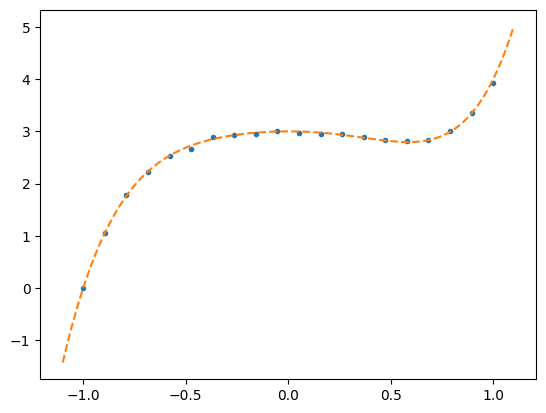

In [51]:
SIGMA=.025 # noise levels
N_obs = 20 # number of observations

# train data
x = torch.linspace(-1,1,N_obs)
y_obs = 2*x**5 - x**2 + 3 + torch.normal(0, SIGMA, x.shape)

# test data
x_plot = torch.linspace(-1.1,1.1,1000)
y_plot = 2*x_plot**5 - x_plot**2 + 3
plt.plot(x.numpy(), y_obs.numpy(), '.')
plt.plot(x_plot.numpy(), y_plot.numpy(), '--')
plt.show()


Now lets fit this. In order to make this work though, we need to do some trickery: immediate clamping down on 3 non-zero coefficients is very hard, resulting in convergence issues. It is however possible to soften the requirements and ask for 5 non-zero terms with a 'soft' restraint. Once we have this fitted, we can use those coeficients to start anew and clamp down harder.

First, lets take it easy

iteration 0000 loss function 18.769
iteration 0100 loss function 0.580
iteration 0200 loss function 0.114
iteration 0300 loss function 0.032
iteration 0400 loss function 0.004


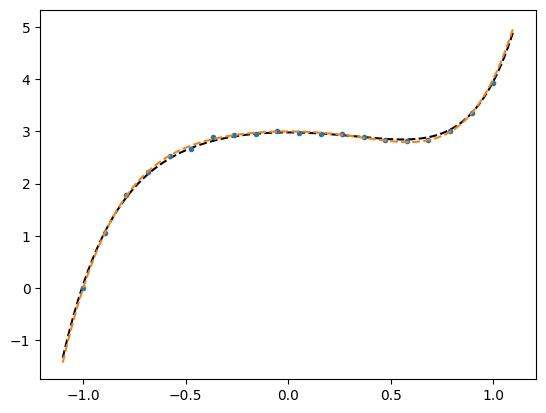

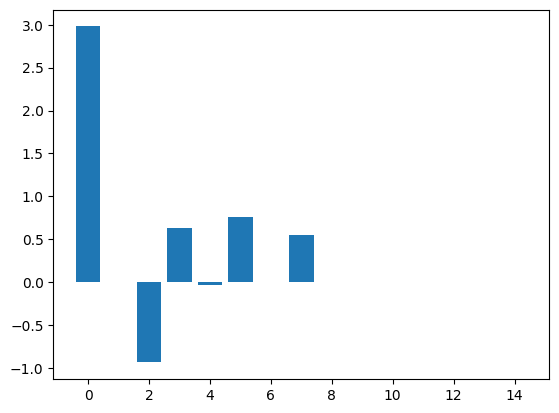

In [52]:

funct = MyFunction(torch.ones(K))
n_epochs = 500
learning_rate=.01
max_norm = 1

optimizer = optim.Adam(funct.parameters(), lr=learning_rate)
#optimizer = optim.SGD(funct.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.999)  # Reduce LR every 10 steps
criterion = OverboardLoss(nn.MSELoss(),.1, 5, 5)


# Training loop
for ii in range(n_epochs):
    optimizer.zero_grad()  # Zero out gradients
    y_pred = funct(x)  # Compute function
    loss_actual = criterion(y_pred, y_obs, funct.coefs)  # Get the loss
    loss_actual.backward()  # Compute gradients
    torch.nn.utils.clip_grad_norm_(funct.parameters(), max_norm=max_norm)
    optimizer.step()  # Update parameters
    scheduler.step()

    if not ii%100:
        print(f"iteration {ii:04} loss function {loss_actual.item():4.3f}")


x_for_plotting = torch.linspace(-1.1,1.1,1000)
with torch.no_grad():
    y_for_plotting = funct(x_for_plotting)

plt.plot(x_for_plotting.numpy(), y_for_plotting.numpy(), '--', c='black')
plt.plot(x, y_obs, '.')
plt.plot(x_plot, y_plot,'--')
plt.show()
plt.bar( np.arange(K), funct.coefs.detach())
plt.show()

my_coefs = funct.coefs.clone()

Now we have a decent set of coefficients, we can clamp down harder.

iteration 0000 loss function 10.791
iteration 1000 loss function 0.013
iteration 2000 loss function 0.011
iteration 3000 loss function 0.011
iteration 4000 loss function 0.007


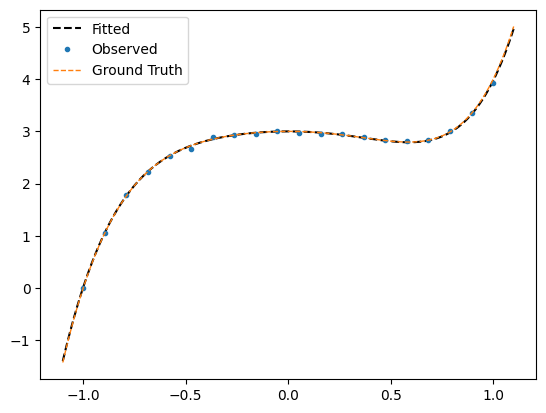

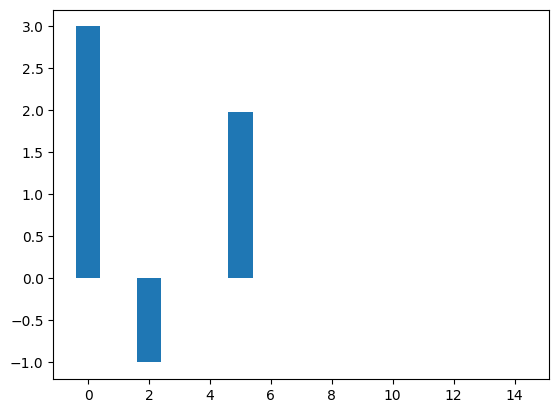

In [53]:
funct = MyFunction(my_coefs)
n_epochs = 5000
learning_rate=.001
max_norm = 1

optimizer = optim.Adam(funct.parameters(), lr=learning_rate)
#optimizer = optim.SGD(funct.parameters(), lr=learning_rate)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.999)

delta = 100.0
weight = 1

criterion = OverboardLoss(nn.MSELoss(), weight, delta, 3)


# Training loop
for ii in range(n_epochs):
    optimizer.zero_grad()  # Zero out gradients
    y_pred = funct(x)  # Compute function
    loss_actual = criterion(y_pred, y_obs, funct.coefs)  # Get the loss
    loss_actual.backward()  # Compute gradients
    torch.nn.utils.clip_grad_norm_(funct.parameters(), max_norm=max_norm)
    optimizer.step()  # Update parameters
    scheduler.step()

    if not ii%1000:
        print(f"iteration {ii:04} loss function {loss_actual.item():4.3f}")


with torch.no_grad():
    y_for_plotting = funct(x_for_plotting)

plt.plot(x_for_plotting.numpy(), y_for_plotting.numpy(), '--', c='black')
plt.plot(x, y_obs, '.')
plt.plot(x_plot, y_plot, '--', lw=1)
plt.legend(["Fitted","Observed","Ground Truth"])
plt.show()

plt.bar( np.arange(K), funct.coefs.detach())
plt.show()



In the end, fitting a function requires tuning a lot of things

- learning rate
- regularization terms
- specific optimizer
- the model you use
- the data you have

